In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


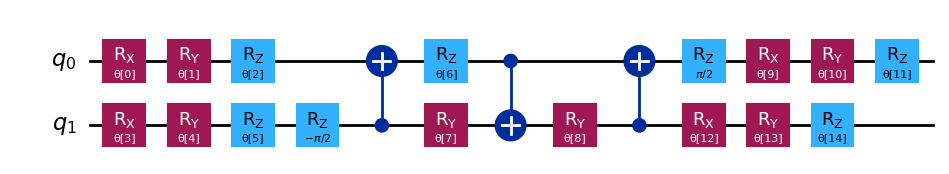

In [2]:
# We now define a two qubit unitary to include additional rotation matrices on either side to fully explore the U(4) space.
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rx(params[0], 0)
    target.ry(params[1], 0)
    target.rz(params[2], 0)
    target.rx(params[3], 1)
    target.ry(params[4], 1)
    target.rz(params[5], 1)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[6], 0)
    target.ry(params[7], 1)
    target.cx(0, 1)
    target.ry(params[8], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    target.rx(params[9], 0)
    target.ry(params[10], 0)
    target.rz(params[11], 0)
    target.rx(params[12], 1)
    target.ry(params[13], 1)
    target.rz(params[14], 1)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=15)
circuit = conv_circuit(params)
circuit.draw("mpl")

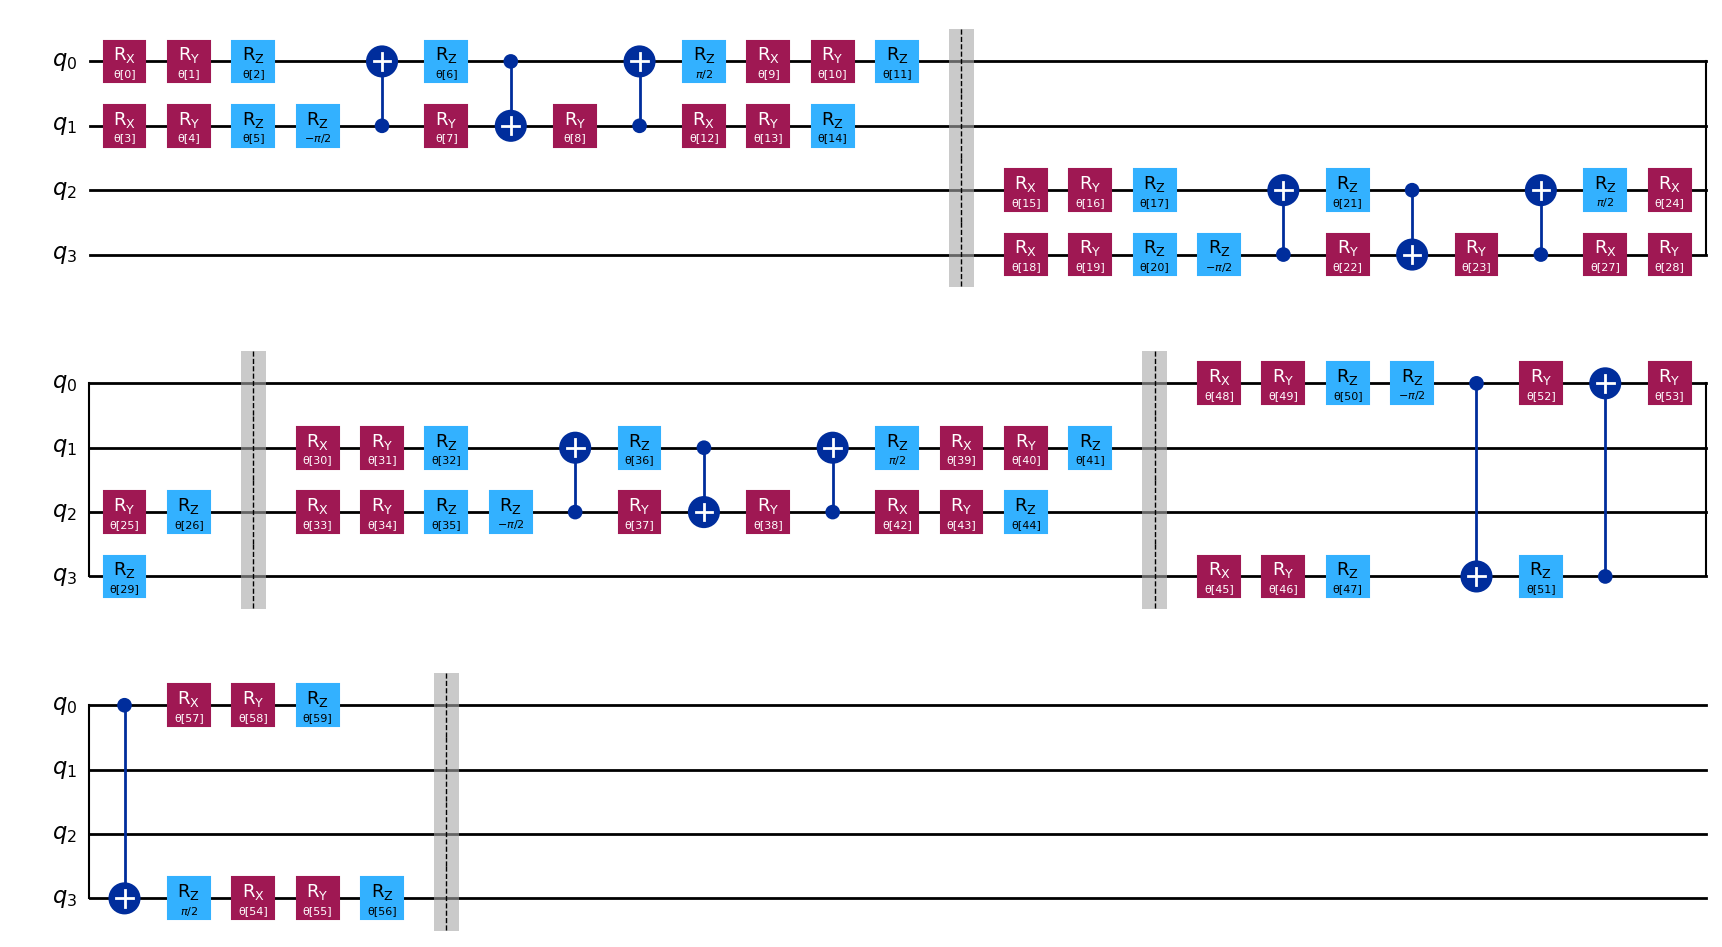

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

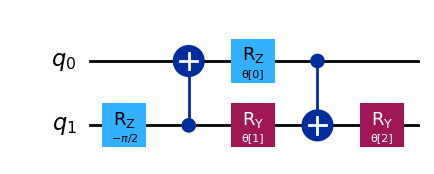

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

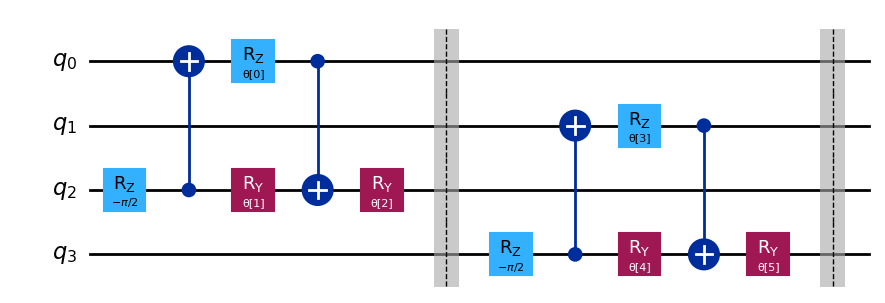

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-11-29 12:19:12.314750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732911552.326588   21513 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732911552.330085   21513 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 12:19:12.342171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [8]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


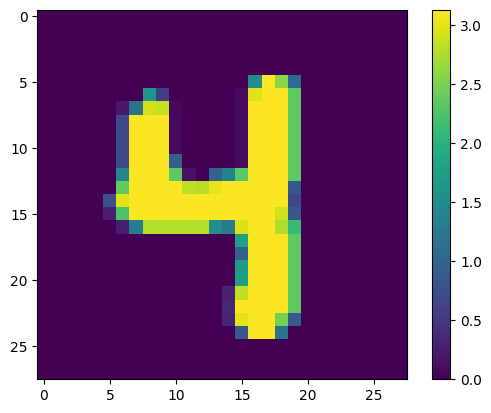

In [9]:
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [10]:
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

W0000 00:00:1732911554.737016   21513 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4


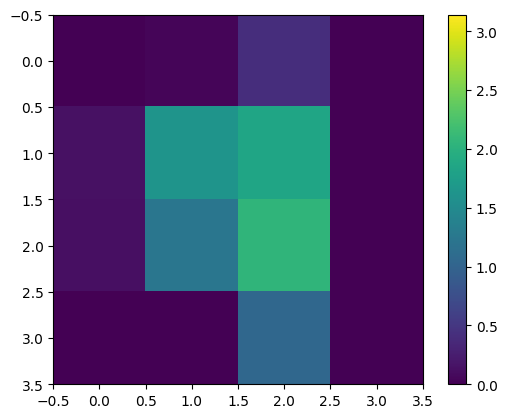

In [11]:
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [13]:
import collections
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 11973
Number of unique  3 's:  6131
Number of unique  4 's:  5842
Number of unique contradicting labels:  0

Initial number of images:  11973
Remaining non-contradicting unique images:  11973
Number of unique images: 1992
Number of unique  3 's:  1010
Number of unique  4 's:  982
Number of unique contradicting labels:  0

Initial number of images:  1992
Remaining non-contradicting unique images:  1992


In [14]:
x_reshaped = []
x1_reshaped = []

for g in resized_train_images:
    x_reshaped.append(g.reshape(1,16))

for g in resized_test_images:
    x1_reshaped.append(g.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    final_x.append(entry[0])

for entry in x1_reshaped:
    final_x1.append(entry[0])

# Easier to work with names
x = final_x
y = train_labels
x1 = final_x1
y1 = test_labels

# Setting labels to 0 or 1 to properly process in samplerqnn.
y_temp = []
y1_temp = []

for entry in y:
    if entry == a:
        y_temp.append(0)
    elif entry == b:
        y_temp.append(1)
y=y_temp

for entry in y1:
    if entry == a:
        y1_temp.append(0)
    elif entry == b:
        y1_temp.append(1)
y1=y_temp

x = np.asarray(final_x)
y = np.asarray(y)
x1 = np.asarray(final_x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:1000]
y = y[0:1000]
x1 = x1[0:1000]
y1 = y1[0:1000]

print(x)
print(y)

[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.2599765  0.23609087 0.72788393 ... 0.         0.72712976 0.05204559]
 [0.02086852 0.22427376 0.49481025 ... 0.         0.77917534 0.        ]
 [0.         0.8033124  0.03394278 ... 0.36306196 0.6207757  0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1
 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1
 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 

In [15]:
# Helper Functions to fix up data
def count(y):
    counta = 0
    countb = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
    return(counta, countb)

def balance_lists(x, y, max_count=452):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1

    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [16]:
# Further Data Cleaning Using Helper Functions
print("original:", count(y))

x,y = balance_lists(x, y)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (477, 523)
balanced: (452, 452)
shuffled: (452, 452)
final: [[0.         0.         0.37110773 ... 0.2031538  0.2562051  0.        ]
 [0.         0.47394174 0.68237555 ... 0.8696894  0.31353068 0.        ]
 [0.         0.         0.28185079 ... 0.         0.49732456 0.        ]
 ...
 [0.         0.19787382 0.         ... 0.         0.42667326 0.        ]
 [0.         0.3575306  0.7133012  ... 0.8533465  0.59663856 0.        ]
 [0.         0.00754284 0.22603375 ... 0.722604   0.02212566 0.        ]]
[1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1
 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1
 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0
 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0
 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0
 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0

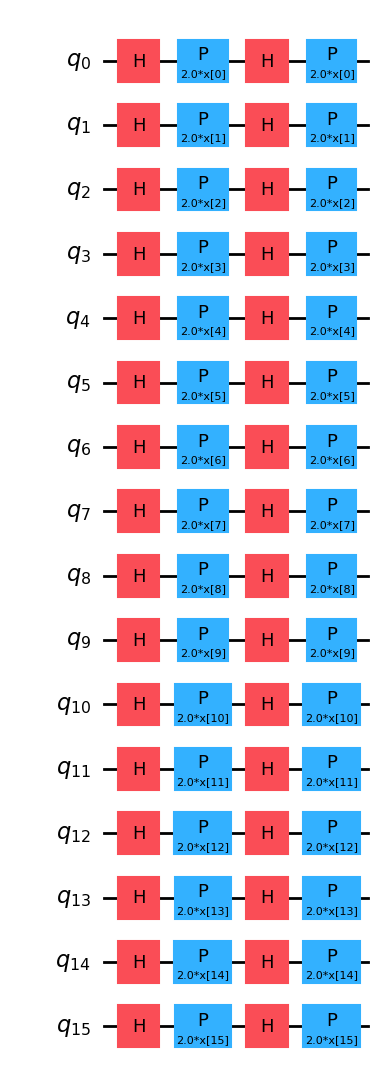

In [17]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

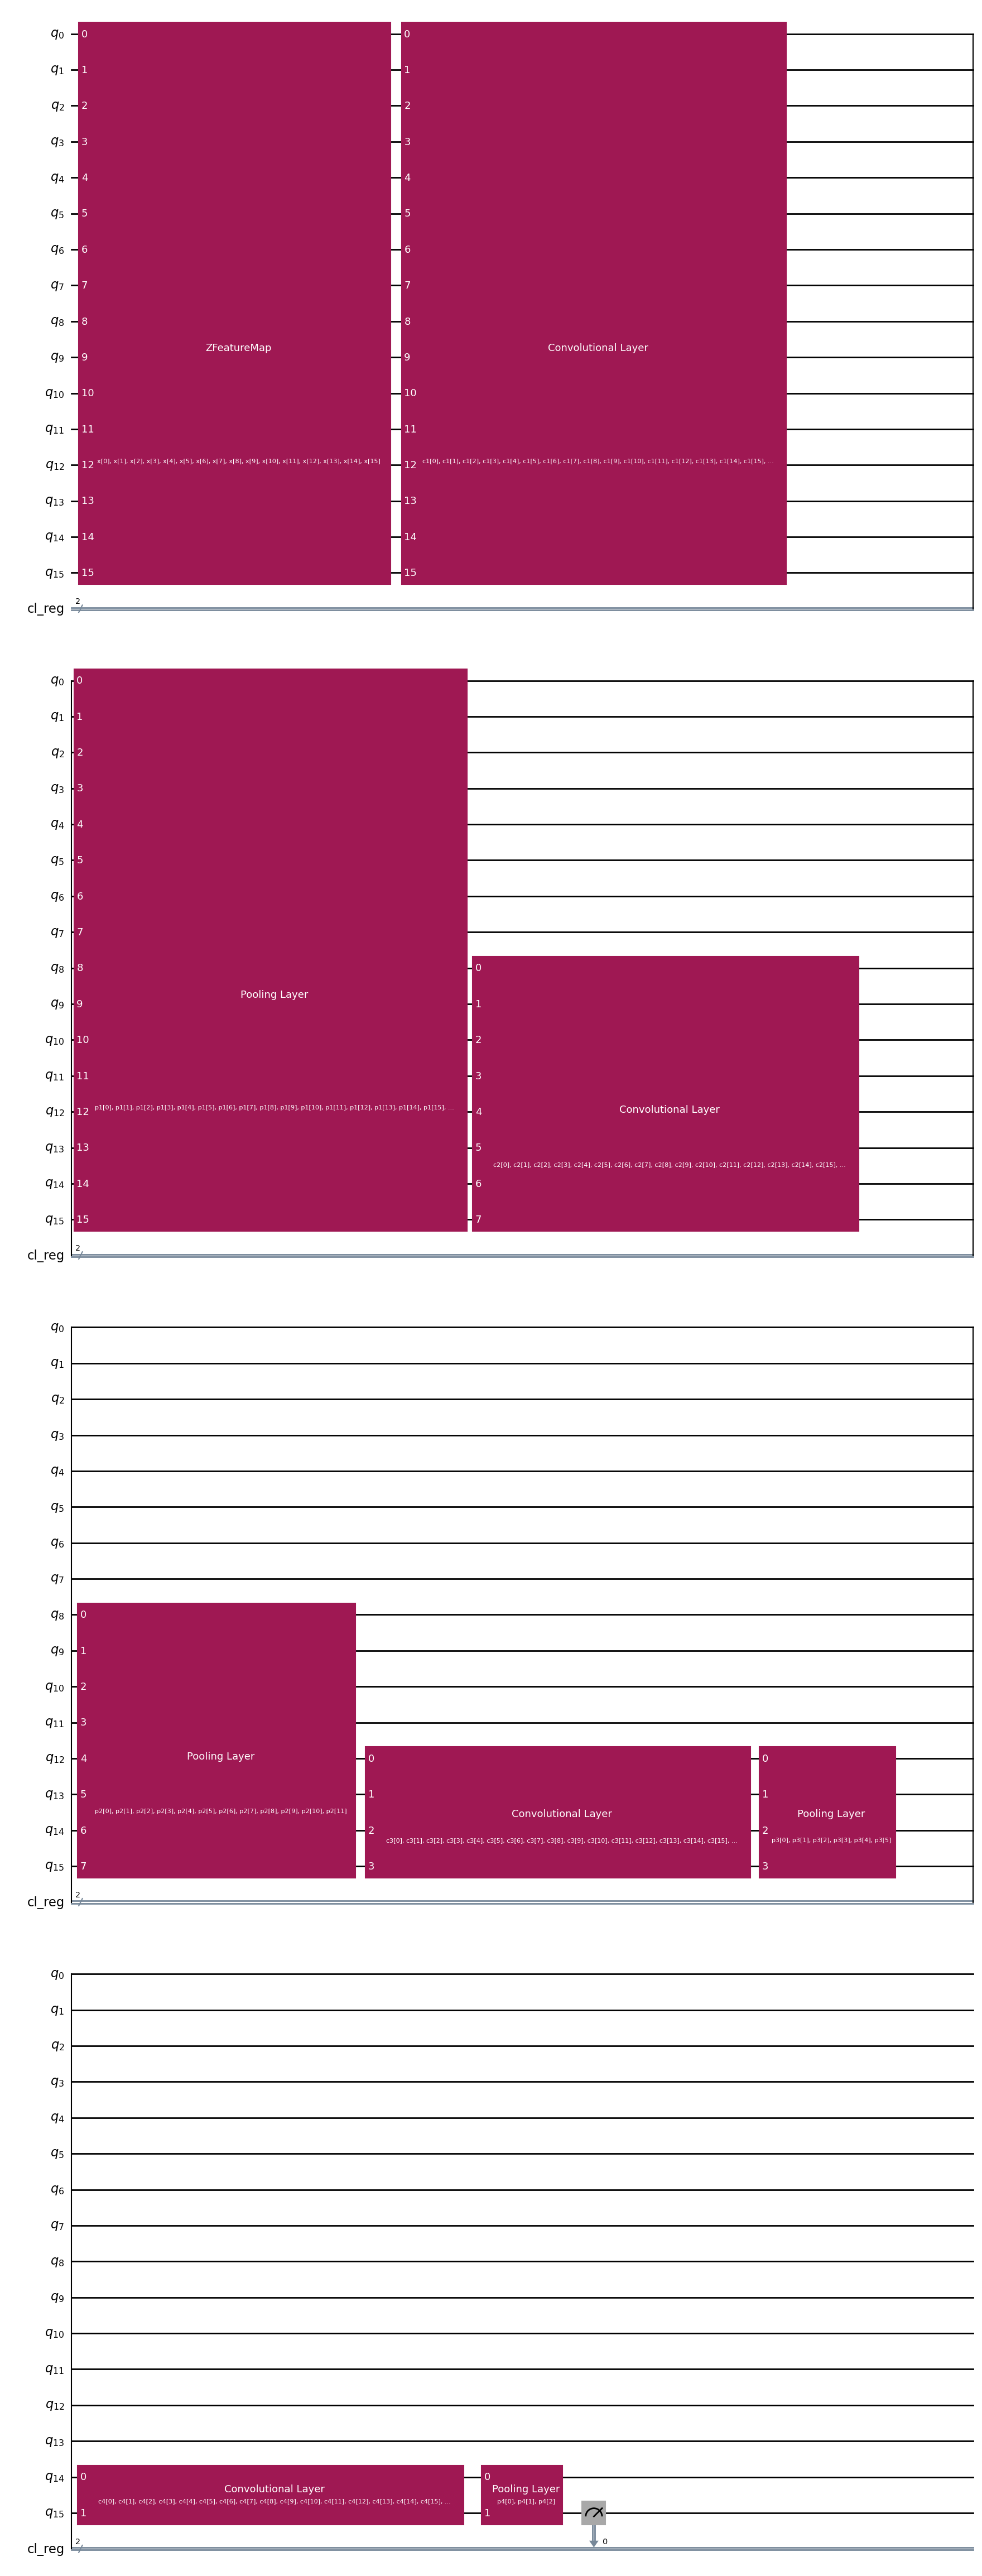

In [ ]:
# Ansatz Instantiation
from qiskit import ClassicalRegister, QuantumRegister
q_reg = QuantumRegister(16, "q_reg")
cl_reg = ClassicalRegister(1, "cl_reg")
ansatz = QuantumCircuit(q_reg, cl_reg, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Fourth Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)
ansatz.measure(-1,0)

# Combining the feature map and ansatz
circuit = QNNCircuit(16)
circuit.feature_map = feature_map
circuit.ansatz = ansatz
display(circuit.draw("mpl"))

In [19]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print("objective function value", objective_func_vals)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [20]:
# Check GPU Availability
from qiskit_aer import AerSimulator
print(AerSimulator().available_devices())
print(AerSimulator().available_methods())

('CPU', 'GPU')
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')


In [21]:
# Setup EstimatorQNN with GPU/Statevector Configuration
from qiskit_aer.primitives import Sampler

sampler = Sampler()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")

classifier = SamplerQNN(
    sampler = sampler,
    circuit = circuit,
    output_shape = 2,
    interpret = lambda x: x,
)

/tmp/ipykernel_21513/3177032928.py:8: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  classifier = SamplerQNN(


In [22]:
# Classifier to forward and backward pass data (default loss = squared_error)
classifier = NeuralNetworkClassifier(
    classifier,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
    warm_start=True,
)

objective function value [np.float64(0.5000270067063053), np.float64(0.5007464653622787), np.float64(0.4978545872511062), np.float64(0.4981365372649336), np.float64(0.4979366876382743), np.float64(0.4959219873478982), np.float64(0.4947326120022124), np.float64(0.4952824685425885), np.float64(0.4930387513827434), np.float64(0.49291560080199115), np.float64(0.4948028294386062), np.float64(0.4948006689021018), np.float64(0.49306683835730086), np.float64(0.49471748824668144), np.float64(0.4930247078954646), np.float64(0.4939569793971239), np.float64(0.4938068221100664), np.float64(0.4931835073285398), np.float64(0.49278488834347345), np.float64(0.493021467090708), np.float64(0.4932105140348451), np.float64(0.49232253353152655), np.float64(0.4917078608960177), np.float64(0.49040721792035397), np.float64(0.4911763689159292), np.float64(0.4941525079507743), np.float64(0.49216481436670356), np.float64(0.4925213028899336), np.float64(0.4921777775857301), np.float64(0.4926563364214602), np.float

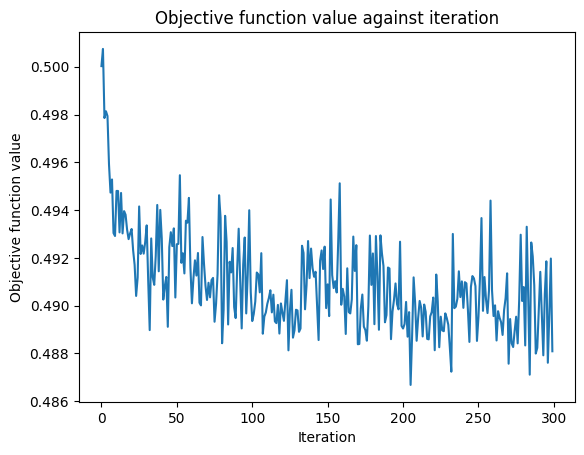

[array([7.03599230e-01, 1.38251157e+00, 3.12394169e-01, 5.87177120e-01,
       1.26328920e+00, 1.73939137e+00, 5.44931769e-01, 1.69850336e+00,
       1.18365172e+00, 3.95975090e-01, 9.81307181e-01, 7.51358799e-02,
       4.96257736e-01, 3.41509854e-01, 5.27406584e-01, 9.65402257e-01,
       9.35927006e-01, 1.18724581e+00, 3.53769293e-01, 3.92251017e-01,
       1.02585858e+00, 1.96542151e+00, 1.24195801e+00, 5.56526937e-01,
       8.31875073e-01, 8.21431182e-01, 9.76121553e-01, 6.57870299e-02,
       2.20606483e-01, 5.22625317e-01, 1.79224467e-01, 1.77121080e+00,
       3.03747774e-01, 2.68102277e-01, 4.23683139e-01, 2.62001014e-01,
       2.29259048e-01, 6.07368646e-01, 2.08632199e-01, 2.09473275e-01,
       2.78839006e-01, 5.78121699e-01, 3.69039937e-02, 3.32649828e-01,
       7.12757480e-01, 1.27148694e-01, 9.64401678e-01, 9.11922884e-01,
       3.78765806e-01, 2.46670706e-01, 8.65641434e-01, 4.41771596e-01,
       8.13172559e-01, 1.19574980e-01, 8.64634192e-01, 7.71525651e-01,
     

In [23]:
%%time
# Checkpoint Arrays
cpt_weights = []
cpt_train = []
cpt_test = []

for i in range(3):
    # Shuffling
    shuffle(x,y)
    print(x,y)

    # Run Fit
    classifier.fit(x, y)

    # Checking checkpoint data for overfitting/underfitting signs
    cpt_weights.append(classifier.weights)
    cpt_train.append(f"{np.round(100 * classifier.score(x, y), 2)}%")
    cpt_test.append(f"{np.round(100 * classifier.score(x1, y1), 2)}%")

    # Logs to monitor performance
    print(cpt_weights, cpt_train, cpt_test)

# Saving predicted values for test data to display later
y_predict = classifier.predict(x1)

In [24]:
print(cpt_weights, cpt_train, cpt_test)

[array([7.03599230e-01, 1.38251157e+00, 3.12394169e-01, 5.87177120e-01,
       1.26328920e+00, 1.73939137e+00, 5.44931769e-01, 1.69850336e+00,
       1.18365172e+00, 3.95975090e-01, 9.81307181e-01, 7.51358799e-02,
       4.96257736e-01, 3.41509854e-01, 5.27406584e-01, 9.65402257e-01,
       9.35927006e-01, 1.18724581e+00, 3.53769293e-01, 3.92251017e-01,
       1.02585858e+00, 1.96542151e+00, 1.24195801e+00, 5.56526937e-01,
       8.31875073e-01, 8.21431182e-01, 9.76121553e-01, 6.57870299e-02,
       2.20606483e-01, 5.22625317e-01, 1.79224467e-01, 1.77121080e+00,
       3.03747774e-01, 2.68102277e-01, 4.23683139e-01, 2.62001014e-01,
       2.29259048e-01, 6.07368646e-01, 2.08632199e-01, 2.09473275e-01,
       2.78839006e-01, 5.78121699e-01, 3.69039937e-02, 3.32649828e-01,
       7.12757480e-01, 1.27148694e-01, 9.64401678e-01, 9.11922884e-01,
       3.78765806e-01, 2.46670706e-01, 8.65641434e-01, 4.41771596e-01,
       8.13172559e-01, 1.19574980e-01, 8.64634192e-01, 7.71525651e-01,
     

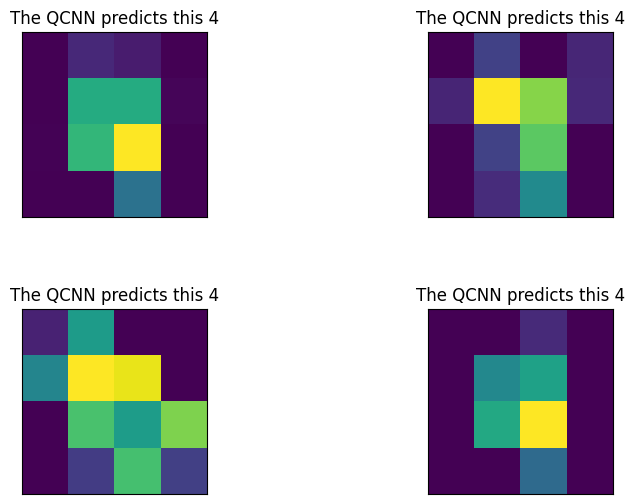

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [26]:
# Printing Actual Data
y1[:1000]

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,

In [27]:
# Printing Predicted Data for Comparision
y_predict[:1000]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [28]:
# Printing Weights for Backup Checkpoint
classifier.weights

array([7.03599230e-01, 1.38251157e+00, 1.31239417e+00, 5.87177120e-01,
       2.26328920e+00, 1.73939137e+00, 1.54493177e+00, 1.69850336e+00,
       1.18365172e+00, 3.95975090e-01, 9.81307181e-01, 7.51358799e-02,
       4.96257736e-01, 3.41509854e-01, 5.27406584e-01, 9.65402257e-01,
       9.35927006e-01, 1.18724581e+00, 3.53769293e-01, 3.92251017e-01,
       1.02585858e+00, 1.96542151e+00, 1.24195801e+00, 1.55652694e+00,
       8.31875073e-01, 8.21431182e-01, 9.76121553e-01, 6.57870299e-02,
       2.20606483e-01, 5.22625317e-01, 1.79224467e-01, 1.77121080e+00,
       3.03747774e-01, 2.68102277e-01, 4.23683139e-01, 2.62001014e-01,
       2.29259048e-01, 6.07368646e-01, 2.08632199e-01, 2.09473275e-01,
       2.78839006e-01, 5.78121699e-01, 3.69039937e-02, 3.32649828e-01,
       7.12757480e-01, 1.27148694e-01, 9.64401678e-01, 9.11922884e-01,
       3.78765806e-01, 2.46670706e-01, 8.65641434e-01, 4.41771596e-01,
       8.13172559e-01, 1.19574980e-01, 8.64634192e-01, 7.71525651e-01,
      

In [29]:
# Saving Model
classifier.save("Classifier2ClassCircuit1Enhanced_MSE")